# LangGraph工作模式：工作流与智能体

## 1 先搞清楚核心区别————Workflow vs Agents

|**维度**|	**Workflows（工作流）**|	**Agents（智能体）**|
|--|--|--|
|**路径特点**|	预定义代码路径（固定步骤顺序）|	动态自主决策（无固定路径，根据环境反馈调整）|
|**自主性**|	完全按预设逻辑执行，无自主选择|	可自主决定使用哪些工具、执行哪些步骤|
|**适用场景**|	任务流程固定、可拆解为明确步骤（如文档翻译、内容校验）|	任务结果 / 步骤不可预测（如复杂计算、动态问题解答）|
|**核心逻辑**|	「输入→预定义步骤→输出」|	「输入→LLM 决策→工具调用→反馈→再决策」的循环|

**一句话总结**：工作流是 “按剧本演戏”，智能体是 “即兴发挥”。

## 2 初始化LLM

In [2]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import getpass
import os

load_dotenv()

def set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入{var}:")

api_key = os.getenv("UIUIAPI_API_KEY")
if not api_key:
    set_env("UIUIAPI_API_KEY")
base_url = os.getenv("UIUIAPI_BASE_URL")
if not base_url:
    set_env("UIUIAPI_BASE_URL")

llm = ChatOpenAI(
    api_key=api_key,
    base_url=base_url,
    model="gpt-3.5-turbo",
    temperature=0.2,
)

## 3 基础能力 ———— 增强LLM（结构化输出+工具绑定）

LLM 默认输出是自然语言，而工作流 / 智能体需要 **固定格式的结果** 或 **调用工具的能力**，这一步教你如何增强 LLM：

### 3.1 增强1：结构化输出（让LLM返回固定格式数据）

用 Pydantic 定义结果结构，强制 LLM 按格式输出（如生成搜索查询时，必须包含 “查询词” 和 “理由”）：

In [8]:
from pydantic import BaseModel, Field

# 1. 定义结构化输出的Schema（相当于“结果模板”）
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="优化后的网页搜索关键词")
    justification: str = Field(None, description="该关键词与用户需求的关联理由")

# 2. 给LLM绑定结构化输出能力
structured_llm = llm.with_structured_output(
    SearchQuery,
)

# 3. 调用增强后的LLM
output = structured_llm.invoke("Langchain与LangGraph的关系与特点是什么？")

print("搜索关键词：", output.search_query)
print("关联理由：", output.justification)


D:\chang\app\Anaconda\envs\py312\Lib\site-packages\langchain_openai\chat_models\base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


搜索关键词： Langchain与LangGraph的关系与特点
关联理由： 了解Langchain与LangGraph之间的关系与特点


**核心作用**：避免 LLM 输出杂乱的自然语言，方便后续步骤直接使用结果（如自动执行搜索）。

### 3.2 增强2：工具绑定（让LLM能调用自定义工具）

**目标**：定义一个工具函数（如乘法），让 LLM 在需要时自动调用：

In [9]:
# 1. 定义工具函数
def multiply(a: int, b: int) -> int:
    """
    计算a和b的乘积
    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b

# 2. 给LLM绑定工具
tools = [multiply]
llm_with_tools = llm.bind_tools(tools)

# 3. 调用LLM，出发工具调用
msg = llm_with_tools.invoke("2乘以3等于多少？")

print("LLM的工具调用请求：", msg.tool_calls) # 包含工具名、参数

LLM的工具调用请求： [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_cGlt6X77QZ6R7DaMtGi2WnEM', 'type': 'tool_call'}]


**代码解析**：

- `bind_tools`：将工具列表传给 LLM，LLM 会判断是否需要调用工具

- `msg.tool_calls`：存储 LLM 的工具调用请求（如 `[{"name":"multiply","args":{"a":2,"b":3}}]`）

- 后续步骤可通过这个请求，实际执行工具函数（见第九步智能体）

## 4 工作流模式1 ———— Prompt Chaining

### 4.1 什么是提示链？

让多个 LLM 调用按顺序执行，**前一个 LLM 的输出作为后一个的输入**，适合拆解为 “分步验证” 的任务（如生成笑话→检查笑点→优化笑话）。

### 4.2 实战：用提示链生成优质笑话

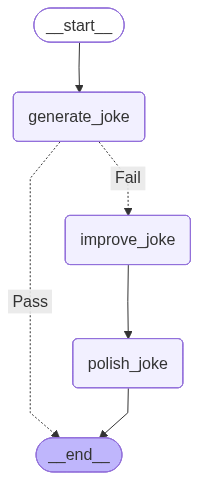

检查是否有笑点: content='True' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 73, 'total_tokens': 74, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_0165350fbb', 'id': 'chatcmpl-CEWapXJrd6AydSOo3u6owzGnuPA9I', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--34bfeba8-f3a9-438e-a088-a4f7a2f5d1f8-0' usage_metadata={'input_tokens': 73, 'output_tokens': 1, 'total_tokens': 74, 'input_token_details': {}, 'output_token_details': {}}
初始笑话： 为什么猫咪不喜欢在雨天出门玩？因为它们怕变成“湿猫”！
笑话通过检查，无需优化！


In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# 1. 定义工作流的“状态”
class State(TypedDict):
    topic: str # 笑话主题
    joke: str  # 初始生成的笑话
    improved_joke: str # 优化后的笑话
    final_joke: str    # 最终润色的笑话

# 2. 定义节点
def generate_joke(state: State):
    """
    节点1：生成初始笑话
    """
    msg = llm.invoke(f"写一个关于{state['topic']}的短笑话")
    return {"joke": msg.content} # 更新状态中的'joke'字段

def check_punchline(state: State):
    """
    节点2：判断笑话是否有笑点
    """
    msg = llm.invoke(f"判断笑话：{state['joke']}是否有笑点，如果有返回字符串'True'，否则返回'False'")
    print("检查是否有笑点:", msg)
    if "True" in msg.content:
        return "Pass" # 有笑点，直接结束
    return "Fail"     # 无笑点，需要优化

def improve_joke(state: State):
    """节点3：优化无笑点的笑话（添加双关语）"""
    msg = llm.invoke(f"给这个笑话加双关语，让它更有趣：{state['joke']}")
    return {"improved_joke": msg.content}  # 更新“improved_joke”

def polish_joke(state: State):
    """节点4：最终润色（添加惊喜转折）"""
    msg = llm.invoke(f"给这个笑话加一个惊喜转折：{state['improved_joke']}")
    return {"final_joke": msg.content}  # 更新“final_joke”

workflow = StateGraph(State)

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {
        "Fail": "improve_joke",
        "Pass": END
    }
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

state = chain.invoke({"topic": "cats"})
print("初始笑话：", state["joke"])
if "improved_joke" in state:
    print("优化后笑话：", state["improved_joke"])
    print("最终笑话：", state["final_joke"])
else:
    print("笑话通过检查，无需优化！")


**关键解析**

- **State（状态）**：相当于工作流的 “共享内存”，所有节点都能读取和更新状态中的字段

- **节点（Node）**：分为 “执行节点”（如 generate_joke，调用 LLM）和 “判断节点”（如check_punchline，逻辑判断）

- **条件边（Conditional Edges）**：让工作流支持 “分支”，不是固定单一路径

## 5 工作流模式2 —— Parallelization（并行化）

### 5.1 什么是并行化

让多个 LLM 任务 **同时执行**（而非按顺序），适合需要 “多任务同步处理” 的场景（如同时生成笑话、故事、诗歌，再合并结果），核心优势是 **提升速度**。

### 5.2 实战：并行生成“笑话+故事+诗歌”

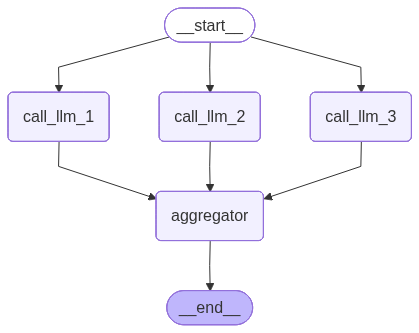

关于cats的创作合集：

笑话：为什么猫咪喜欢在键盘上踩来踩去？

因为它们想成为“键盘侠”！

故事：Tommy had always been afraid of cats. But one day, a stray cat showed up at his doorstep, meowing pitifully. Tommy hesitated at first, but then he slowly reached out his hand to pet the cat. From that day on, they became the best of friends.

诗歌：Graceful and sleek, with eyes so bright,
Cats prowl the night, a silent delight.
Their purrs and meows, a soothing sound,
In their presence, peace is found.


In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# 1. 定义状态
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# 2. 定义并行节点
def call_llm_1(state: State):
    """
    生成笑话
    """
    msg = llm.invoke(f"写一个关于{state['topic']}的笑话")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """生成故事"""
    msg = llm.invoke(f"写一个关于{state['topic']}的短故事（50字内）")
    return {"story": msg.content}

def call_llm_3(state: State):
    """生成诗歌"""
    msg = llm.invoke(f"写一首关于{state['topic']}的四行诗")
    return {"poem": msg.content}

def aggregator(state: State):
    """聚合节点：合并3个并行任务的结果"""
    combined = f"关于{state['topic']}的创作合集：\n\n"
    combined += f"笑话：{state['joke']}\n\n"
    combined += f"故事：{state['story']}\n\n"
    combined += f"诗歌：{state['poem']}"
    return {"combined_output": combined}

workflow = StateGraph(State)

# 为工作流添加节点
workflow.add_node("call_llm_1", call_llm_1)
workflow.add_node("call_llm_2", call_llm_2)
workflow.add_node("call_llm_3", call_llm_3)
workflow.add_node("aggregator", aggregator)

# 为工作流添加边
workflow.add_edge(START, "call_llm_1")
workflow.add_edge(START, "call_llm_2")
workflow.add_edge(START, "call_llm_3")

workflow.add_edge("call_llm_1", "aggregator")
workflow.add_edge("call_llm_2", "aggregator")
workflow.add_edge("call_llm_3", "aggregator")

workflow.add_edge("aggregator", END)

chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

state = chain.invoke({"topic": "cats"})
print(state["combined_output"])


## 6 工作流模式2 —— Routing

### 6.1 什么是路由？

根据 **输入内容的类型**，动态将任务分配给不同的处理节点（如用户输入 “写笑话” 就调用笑话节点，“写诗歌” 就调用诗歌节点），适合 “多场景统一入口” 的任务。

D:\chang\app\Anaconda\envs\py312\Lib\site-packages\langchain_openai\chat_models\base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


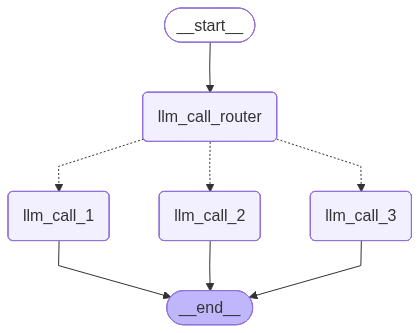

step='joke'
最终结果： 为什么猫喜欢玩捉迷藏？

因为它们喜欢藏在你找不到的地方，然后看着你绝望地四处寻找！


In [13]:
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# 1. 定义路由决策的结构化输出
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(None, description="路由目标：poem=诗歌，story=故事，joke=笑话")

# 2. 增强LLM为"路由决策器"
router_llm = llm.with_structured_output(Route)

# 3. 定义工作流状态
class State(TypedDict):
    input: str
    decision: str
    output: str

# 4. 定义处理节点

def llm_call_1(state: State):
    """处理“故事”需求"""
    result = llm.invoke(f"写一个关于{state['input'].split('关于')[1]}的短故事")
    return {"output": result.content}

def llm_call_2(state: State):
    """处理“笑话”需求"""
    result = llm.invoke(f"写一个关于{state['input'].split('关于')[1]}的笑话")
    return {"output": result.content}

def llm_call_3(state: State):
    """处理“诗歌”需求"""
    result = llm.invoke(f"写一首关于{state['input'].split('关于')[1]}的四行诗")
    return {"output": result.content}

def llm_call_router(state: State):
    """路由节点：判断用户需求类型"""
    decision = router_llm.invoke([
        SystemMessage(content="根据用户输入，判断需求是写诗歌（poem）、故事（story）还是笑话（joke），只返回对应关键词"),
        HumanMessage(content=state["input"])
    ])
    print(decision)
    return {"decision": decision.step}

# 5. 定义路由条件函数（根据决策结果跳转节点）
def route_decision(state: State) -> Literal["llm_call_1", "llm_call_2", "llm_call_3"]:
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

# 6. 构建工作流
workflow = StateGraph(State)

workflow.add_node("llm_call_1", llm_call_1)
workflow.add_node("llm_call_2", llm_call_2)
workflow.add_node("llm_call_3", llm_call_3)
workflow.add_node("llm_call_router", llm_call_router)

workflow.add_edge(START, "llm_call_router")
workflow.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    }
)
workflow.add_edge("llm_call_1", END)
workflow.add_edge("llm_call_2", END)
workflow.add_edge("llm_call_3", END)

chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

state = chain.invoke({"input":"写一个关于猫的笑话"})
print("最终结果：", state["output"])


**关键解析**

- **路由决策器**：用结构化输出的 LLM 判断输入类型，确保决策结果是固定的（poem/story/joke），避免歧义

- **路由条件函数**：将 LLM 的决策结果映射到具体的处理节点，实现 “动态跳转”

## 7 工作流模式 4——Orchestrator-Worker（编排器 - 工作器）

### 7.1 什么是编排器-工作器

- **Orchestrator（编排器）**：拆分复杂任务为多个子任务，分配给工作器

- **Worker（工作器）**：执行单个子任务

- **核心用途**：处理 “子任务数量不固定” 的场景（如生成报告时，章节数量由 LLM 决定，而非预定义）

### 7.2 实战：生成多章节报告（动态子任务）

In [19]:
llm = ChatOpenAI(
    api_key=api_key,
    base_url=base_url,
    model="gpt-4.1",
    temperature=0.2,
)

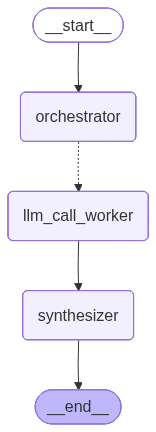

# LLM缩放定律（Scaling Laws）报告

# 1. 引言与背景

## 1.1 大语言模型（LLM）的发展历程

近年来，人工智能领域经历了快速发展，尤其是在自然语言处理（NLP）方向。大语言模型（Large Language Model, LLM）作为NLP的核心技术之一，已经成为推动AI进步的重要引擎。从早期的基于规则和统计的方法，到深度学习的广泛应用，语言模型经历了多次技术革新。

- **早期阶段**：最初的语言模型主要依赖于n-gram统计方法，通过分析词语之间的共现概率来进行文本生成和理解。这些方法虽然简单，但在处理复杂语义和长距离依赖时存在明显局限。
- **神经网络模型**：随着深度学习的发展，循环神经网络（RNN）、长短期记忆网络（LSTM）等结构被引入到语言建模任务中，显著提升了模型的表达能力。
- **Transformer架构的突破**：2017年，Google提出了Transformer架构，极大地改善了模型的并行计算能力和上下文理解能力。随后，基于Transformer的模型如BERT、GPT系列、T5等相继问世，推动了LLM的规模化发展。
- **规模化趋势**：自GPT-2、GPT-3等模型发布以来，研究者发现随着模型参数规模的提升，模型在多项任务上的表现持续提升。这一现象引发了对“缩放定律”的系统性研究。

## 1.2 缩放定律的提出背景

随着LLM规模的不断扩大，研究者们注意到模型性能与规模之间存在某种规律性关系。缩放定律（Scaling Laws）即描述了模型性能（如损失、准确率等）与模型参数数量、训练数据量、计算资源之间的定量关系。

- **最早的观察**：OpenAI等机构在训练大规模Transformer模型时，发现无论是参数数量、训练数据量还是计算量的增加，模型性能都呈现出幂律型的持续提升，而非早期预期的饱和或递减。
- **系统性研究**：2020年，OpenAI发布了关于语言模型缩放定律的系统性论文，首次明确提出并量化了参数规模、数据量、计算量与模型性能之间的关系。这一发现为后续模型设计和资源分配提供了理论依据。
- **理论与实践结合**：缩放定律不仅在理论上揭示了模型扩展的潜力，也在实际工程中指导了模型训练的策略，如如何合理分配计算资源、选择合适的数据规模等。

## 1.3 缩放定律在人工智能领域的重要性与研究意义

缩放定律的提出，对人工智能领域产生了深远影响：

- **指导模型设计**：通过缩放定律，研究者可以预测模型扩展后的性能，合理规划参数规模和训练数据量，避免资源浪费。
- **推动模型极限探索**：缩放定律揭示了模型性能提升的潜力，激励业界不断挑战更大规模的模型，推动AI能力的边界。
- **优化资源分配**：在实际应用中，缩放定律帮助企业和研究机构在有限资源下做出最优决策，实现性能与成本的平衡。
- **促进理论研究**：缩放定律为理解深度学习模型的泛化能力、学习机制等提供了新的理论视角，推动了AI基础理论的发展。

总之，LLM缩放定律不仅是大语言模型发展的里程碑，也是人工智能领域持续创新和突破的重要理论基础。理解其背景和意义，有助于把握AI技术的未来发展方向。

---

## 2. LLM缩放定律的原理与实证

### 2.1 缩放定律的基本内容

大规模语言模型（Large Language Models, LLMs）近年来取得了突破性进展。研究发现，模型的性能与其参数规模、训练数据量和计算资源之间存在可预测的关系，这被称为**缩放定律（Scaling Laws）**。缩放定律揭示了只要持续增加模型规模和数据量，模型性能（如困惑度、准确率等）会持续提升，且这种提升遵循一定的数学规律。

#### 2.1.1 参数规模与性能

参数规模指的是神经网络中可学习参数的总数。实验表明，在一定范围内，随着参数数量的增加，模型的性能会以幂律（power law）方式提升。即使在数据量充足的情况下，增大模型规模通常能带来更低的损失和更好的泛化能力。

#### 2.1.2 数据量与性能

训练数据量同样对模型性能有显著影响。缩放定律指出，模型在数据量充足的情况下才能充分发挥其容量。数据量不足时，模型容易过拟合，无法获得最佳性能。

#### 2.1.3 计算资源与性能

训练大模型需要大量计算资源。缩放定律还涉及到计算预算（如FLOPs），即在给定计算资源下，如何合理分配参数规模和数据量以获得最佳性能。

### 2.2 主要缩放定律公式

OpenAI等机构通过大量实验，总结出如下典型的缩放定律公式：

#### 2.2.1 损失函数的幂律关系

模型损失（如困惑度）与参数规模（N）、数据量（D）和计算量（C）之间通常满足如下幂律关系：

$$
L(N, D) = L_{\infty} + \frac{A}{N^{\alpha}} + \frac{B}{D^{\beta}}
$$

其中，$L_{\infty}$为理论极限损失，$A$、$B$为常数，$\alpha$、$\beta$为幂律指数。该公式说明，随着$N$和$D$的增加，损失逐渐逼近$L_{\infty}$。

#### 2.2.2 计算预算下的最优分配

给定总计算预算$C$，参数规模$N$和数据量$D$的最优分配关系为：

$$
N \propto D^{\gamma}
$$

其中$\gamma$通常在0.7~1之间。即，模型规模和数据量应按一定比例共同增长，以实现最佳性能。

### 2.3 实验验证与典型案例

#### 2.3.1 GPT系列

OpenAI在GPT-1、GPT-2、GPT-3等模型的训练中，系统性地扩大了模型参数和数据规模。实验结果表明，困惑度等指标随着模型规模和数据量的增加持续下降，符合缩放定律的预测。例如，GPT-3拥有1750亿参数，显著优于前代模型。

#### 2.3.2 PaLM

Google的PaLM模型在参数规模（5400亿）和数据量上进一步提升，实验同样验证了缩放定律。PaLM在多项自然语言理解和生成任务上刷新了SOTA（state-of-the-art）成绩，显示出大模型的强大能力。

#### 2.3.3 其他案例

DeepMind的Chinchilla研究发现，许多大模型在训练时数据量不足，导致未能充分发挥模型容量。通过增加训练数据量，模型性能得以进一步提升，验证了缩放定律的普适性。

### 2.4 适用范围与局限性

#### 2.4.1 适用范围

- **模型类型**：目前缩放定律主要适用于Transformer架构的自回归语言模型。
- **数据类型**：以大规模文本数据为主，部分研究扩展到多模态数据。
- **性能指标**：困惑度、准确率等主流指标。

#### 2.4.2 局限性

- **极限效应**：当模型规模和数据量极大时，性能提升趋于饱和，幂律关系可能失效。
- **数据质量**：缩放定律假设数据分布稳定且高质量，现实中数据噪声和偏差会影响效果。
- **训练效率**：大模型训练成本极高，硬件和能耗成为瓶颈。
- **泛化能力**：缩放定律主要关注训练损失，实际应用中的泛化和鲁棒性仍需进一步研究。

### 2.5 小结

LLM缩放定律为大模型的发展提供了理论指导和工程实践依据。通过合理扩展模型规模和数据量，可以持续提升模型性能。然而，缩放定律也有其适用范围和局限性，未来需要结合新架构、优化算法和高质量数据，进一步突破大模型的能力上限。

---

# 3. 挑战与展望

缩放定律（Scaling Laws）为大规模语言模型（LLM）的发展提供了理论指导和实践参考。它揭示了模型规模、训练数据量、计算资源与模型性能之间的关系，为模型设计和资源分配提供了科学依据。然而，随着LLM规模的不断扩大，缩放定律的应用也面临诸多挑战。未来的发展既充满机遇，也伴随着不确定性和技术壁垒。

## 3.1 缩放定律对未来LLM发展的影响

### 3.1.1 模型训练策略

缩放定律表明，增加模型参数、训练数据和计算量通常能提升模型性能，但提升幅度呈现递减趋势。未来LLM的训练策略将更加依赖于缩放定律的指导：

- **参数规模选择**：开发者可根据缩放定律预测不同参数规模下的性能收益，合理规划模型大小，避免资源浪费。
- **数据与计算权衡**：通过缩放定律，研究者可以在数据量和计算预算之间做出最优权衡，实现性能最大化。
- **预训练与微调策略**：缩放定律有助于确定预训练阶段的资源分配，以及微调时的增量收益预测。

### 3.1.2 资源配置

随着模型规模的扩大，资源配置成为核心问题。缩放定律为资源分配提供量化依据：

- **硬件资源**：根据模型规模和预期性能，合理配置GPU/TPU等算力资源，优化训练效率。
- **存储与带宽**：大模型需要海量存储和高速数据传输，缩放定律有助于提前预估需求，避免瓶颈。
- **能耗管理**：缩放定律揭示了能耗与性能的关系，为绿色AI和节能优化提供理论基础。

### 3.1.3 性能预测

缩放定律能够在早期训练阶段预测最终模型性能，降低试错成本：

- **性能上限估计**：通过缩放曲线，提前判断模型扩展的收益是否值得投入更多资源。
- **模型迭代指导**：为模型架构创新和参数调整提供定量参考，提升研发效率。

## 3.2 当前面临的挑战

尽管缩放定律为LLM发展提供了方向，但在实际应用中仍面临多重挑战：

### 3.2.1 成本压力

- **硬件成本**：训练百亿、千亿参数模型需要昂贵的计算设备，普通研究团队难以承受。
- **运维成本**：模型部署和推理同样消耗大量资源，影响商业化落地。

### 3.2.2 能耗问题

- **环境影响**：大规模训练带来的高能耗引发环境和可持续性担忧，绿色AI成为重要议题。
- **能效优化**：如何在保证性能的前提下降低能耗，是未来研究的关键方向。

### 3.2.3 数据瓶颈

- **高质量数据稀缺**：随着模型规模扩大，优质训练数据成为瓶颈，低质量数据可能导致性能停滞或退化。
- **数据隐私与安全**：大规模数据收集面临隐私保护和合规风险，影响数据获取和模型训练。

### 3.2.4 缩放定律的边界

- **性能饱和**：缩放定律并非无限有效，模型规模达到一定程度后，性能提升趋于饱和。
- **新任务适应性**：部分任务对模型规模不敏感，缩放定律的普适性仍需进一步验证。

## 3.3 未来展望与研究方向

面对上述挑战，未来LLM的发展有望在以下方向取得突破：

### 3.3.1 高效训练与推理

- **稀疏化与剪枝**：通过模型稀疏化、参数剪枝等技术，减少计算量和能耗，实现高效训练与推理。
- **混合专家模型**：采用MoE（Mixture of Experts）等架构，提升模型性能的同时降低资源消耗。

### 3.3.2 数据高效利用

- **合成数据与自监督学习**：利用生成模型合成高质量数据，或通过自监督学习挖掘更多信息，缓解数据瓶颈。
- **数据选择与过滤**：开发智能数据筛选算法，提升训练数据的有效性和多样性。

### 3.3.3 缩放定律的扩展与修正

- **多模态缩放定律**：探索文本、图像、语音等多模态数据下的缩放规律，推动跨领域模型发展。
- **任务定制化缩放**：针对不同任务，建立更精细化的缩放模型，提升定制化性能预测能力。

### 3.3.4 可持续与公平AI

- **绿色AI技术**：发展低碳、节能的AI训练和推理方法，推动AI可持续发展。
- **公平性与安全性**：在模型扩展过程中，关注算法公平性和安全性，防止偏见和滥用。

## 3.4 总结

缩放定律为LLM的持续进步提供了理论基础和实践指南，但在成本、能耗、数据等方面的挑战亟需解决。未来，随着高效算法、智能数据利用和绿色AI技术的发展，LLM有望突破现有瓶颈，实现更广泛、更可持续的应用。对缩放定律的深入研究和创新，将持续引领大模型技术的前沿。

In [20]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send  # 关键：动态创建工作器
from IPython.display import Image, Markdown

# 1. 定义报告章节的结构化输出（编排器用它拆分章节）
class Section(BaseModel):
    name: str = Field(description="报告章节名（如“1. 引言”）")
    description: str = Field(description="章节涵盖的核心内容概述")

class Sections(BaseModel):
    sections: List[Section] = Field(description="报告的所有章节列表")

# 2. 增强LLM为“章节规划器”（编排器的核心能力）
planner_llm = llm.with_structured_output(Sections)

# 3. 定义状态（注意：completed_sections用operator.add实现多工作器结果合并）
class State(TypedDict):
    topic: str                # 报告主题
    sections: List[Section]   # 编排器拆分的章节列表
    # 所有工作器的结果会合并到这里（Annotated+operator.add实现累加）
    completed_sections: Annotated[List[str], operator.add]
    final_report: str         # 最终合并的报告

# 4. 定义工作器的状态（工作器只处理单个章节）
class WorkerState(TypedDict):
    section: Section          # 单个章节信息
    completed_sections: Annotated[List[str], operator.add]  # 与主状态共享字段

# 5. 定义节点（编排器节点 + 工作器节点 + 聚合节点）
def orchestrator(state: State):
    """编排器：拆分报告为章节"""
    # 生成章节列表
    report_sections = planner_llm.invoke([
        SystemMessage(content="为报告生成详细的章节规划，至少包含3个章节"),
        HumanMessage(content=f"报告主题：{state['topic']}")
    ])
    return {"sections": report_sections.sections}  # 将章节列表存入状态

def llm_call_worker(state: WorkerState):
    """工作器：写单个章节的内容"""
    section = state["section"]
    # 生成该章节的内容
    result = llm.invoke([
        SystemMessage(content="根据章节名和描述，写该章节的详细内容，用Markdown格式"),
        HumanMessage(content=f"章节名：{section.name}\n章节描述：{section.description}")
    ])
    # 返回该章节的内容（会自动合并到主状态的completed_sections）
    return {"completed_sections": [result.content]}

def synthesizer(state: State):
    """聚合节点：合并所有章节为最终报告"""
    # 合并所有工作器生成的章节内容
    combined_sections = "\n\n---\n\n".join(state["completed_sections"])
    final_report = f"# {state['topic']}\n\n{combined_sections}"
    return {"final_report": final_report}

# 6. 定义工作分配函数（动态创建工作器）
def assign_workers(state: State):
    """为每个章节创建一个工作器（用Send API）"""
    # Send(工作器节点名, 传递给工作器的参数) → 动态生成工作器
    return [Send("llm_call_worker", {"section": section}) for section in state["sections"]]

# 7. 构建编排器-工作器工作流
orchestrator_worker_builder = StateGraph(State)

# 添加节点
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call_worker", llm_call_worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# 边的连接：START→编排器→动态分配工作器→聚合器→END
orchestrator_worker_builder.add_edge(START, "orchestrator")
# 条件边：编排器→动态创建工作器
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",
    assign_workers,  # 分配工作器的函数
    ["llm_call_worker"]  # 工作器节点名
)
# 所有工作器执行完→聚合器
orchestrator_worker_builder.add_edge("llm_call_worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# 8. 编译、可视化、执行
orchestrator_worker = orchestrator_worker_builder.compile()
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# 执行：生成“LLM缩放定律”的报告
state = orchestrator_worker.invoke({"topic": "LLM缩放定律（Scaling Laws）报告"})

# 查看Markdown格式的最终报告
display(Markdown(state["final_report"]))

**关键解析**

- **Send API**：动态创建工作器的核心，根据编排器拆分的子任务数量，自动生成对应数量的工作器

- **共享状态合并**：`completed_sections` 用 `Annotated[List[str], operator.add]` 定义，多个工作器的结果会自动累加（而非覆盖）

- **灵活性**：章节数量由 LLM 决定（而非代码预定义），适合动态任务

## 8 工作流模式 5——Evaluator-Optimizer（评估器 - 优化器）

### 8.1 什么是评估器 - 优化器？

形成 “生成→评估→优化” 的 循环：先生成结果，再评估是否满足要求，不满足则根据反馈重新生成，直到符合标准（如生成笑话→评估是否有趣→不有趣则优化）。

### 8.2 实战：生成 “有趣的笑话”（循环优化）

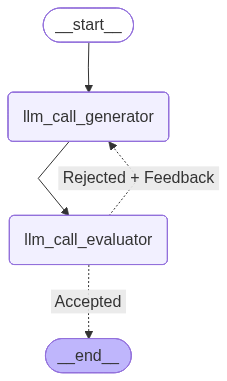

最终有趣的笑话： 当然可以！给你一个关于猫的笑话：

有一天，一只猫走进了图书馆，对图书管理员说：“喵，喵，喵。”

图书管理员很惊讶，但还是递给了它三本书。

第二天，这只猫又来了，说：“喵，喵。”

管理员递给它两本书。

第三天，猫又来了，说：“喵。”

管理员递给它一本书，但这次他决定跟着猫看看它到底要做什么。

猫带着书走到池塘边，把书递给了一只青蛙。

青蛙看了看书，摇摇头说：“呱呱——读过了，读过了！”
评估反馈： 这个笑话有趣之处在于利用了动物的叫声和拟人化的情节。猫的“喵”被理解为借书的数量，青蛙的“呱呱”谐音“读过了”，产生了幽默效果。整体结构完整，结尾有反转，适合轻松场合。可以考虑在讲述时增加一些表情或语气变化，让笑点更突出。


In [21]:
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# 1. 定义评估器结构化输出
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="笑话是否有趣：funny=有趣，not funny=无趣")
    feedback: str = Field(description="若无趣，提供具体的优化建议")

# 2. 增强LLM为“笑话评估器”
evaluator_llm = llm.with_structured_output(Feedback)

# 3. 定义状态
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# 4. 定义节点
def llm_call_generator(state: State):
    """生成节点：生成或优化笑话"""
    if state.get("feedback"):  # 若有反馈，根据反馈优化
        msg = llm.invoke(f"写一个关于{state['topic']}的笑话，参考优化建议：{state['feedback']}")
    else:  # 无反馈，首次生成
        msg = llm.invoke(f"写一个关于{state['topic']}的笑话")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """评估节点：判断笑话是否有趣并给反馈"""
    grade = evaluator_llm.invoke(f"评估这个笑话是否有趣：{state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# 5. 定义循环条件函数（判断是否需要继续优化）
def route_joke(state: State) -> Literal["Accepted", "Rejected + Feedback"]:
    if state["funny_or_not"] == "funny":
        return "Accepted"  # 有趣，结束循环
    else:
        return "Rejected + Feedback"  # 无趣，返回重新生成

# 6. 构建评估-优化循环工作流
optimizer_builder = StateGraph(State)

# 添加节点
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# 边的连接：生成→评估→根据结果决定结束或重新生成
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,  # 接受，结束
        "Rejected + Feedback": "llm_call_generator"  # 拒绝，返回生成节点重新优化
    }
)

# 7. 编译、可视化、执行
optimizer_workflow = optimizer_builder.compile()
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# 执行：生成有趣的“猫”笑话
state = optimizer_workflow.invoke({"topic": "Cats"})

# 查看最终结果
print("最终有趣的笑话：", state["joke"])
print("评估反馈：", state["feedback"])


## 9 进阶 —— 构建自主智能体（Agent）

### 9.1 智能体的核心逻辑

智能体是 “LLM + 工具 + 反馈循环” 的组合，能 **自主决定是否调用工具、调用哪个工具**，无需预定义路径（如用户问 “3 加 4 再加 5 等于多少”，智能体会自主调用 “加法工具” 两次）。

### 9.2 实战：数学计算智能体（调用加减乘除工具）

{'add': StructuredTool(name='add', description='计算两个整数的和\nArgs:\n    a: 第一个整数\n    b: 第二个整数', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000001449703B2E0>), 'multiply': StructuredTool(name='multiply', description='计算两个整数的乘积\nArgs:\n    a: 第一个整数\n    b: 第二个整数', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000014497173100>), 'divide': StructuredTool(name='divide', description='计算两个整数的商\nArgs:\n    a: 第一个整数\n    b: 第二个整数', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000014497038E00>)}


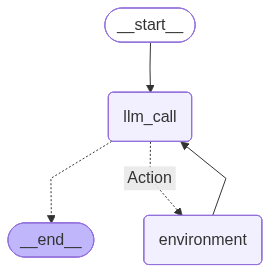

================================ Human Message =================================

3加4，再乘以2等于多少？
================================== Ai Message ==================================
Tool Calls:
  add (call_lUEHCW8BVKI4QU1Pq3foeMkZ)
 Call ID: call_lUEHCW8BVKI4QU1Pq3foeMkZ
  Args:
    a: 3
    b: 4
  multiply (call_zqbykl73jfIZmu74vvtoyjfx)
 Call ID: call_zqbykl73jfIZmu74vvtoyjfx
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

7
================================= Tool Message =================================

14
================================== Ai Message ==================================

3加4等于7，7乘以2等于14，所以结果是14。


In [9]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from typing_extensions import Literal
from IPython.display import Image

load_dotenv()

# 1. 定义工具
@tool
def multiply(a: int, b: int) -> int:
    """
    计算两个整数的乘积
    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """
    计算两个整数的和
    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a + b

@tool
def divide(a: int, b:int) -> float:
    """
    计算两个整数的商
    Args:
        a: 第一个整数
        b: 第二个整数
    """
    if b == 0:
        raise Exception("除数不能为0")
    return a / b

# 2. 准备工具列表，方便后序调用
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
print(tools_by_name)
# 3. 增强LLM
llm = ChatOpenAI(
    base_url=os.getenv("UIUIAPI_BASE_URL"),
    api_key=os.getenv("UIUIAPI_API_KEY"),
    model="gpt-3.5-turbo",
    temperature=0.3
)

llm_with_tools = llm.bind_tools(tools)

# 4. 定义节点（LLM决策节点 + 工具执行节点）
def llm_call(state: MessagesState):
    """LLM决策节点：判断是否需要调用工具，或直接回答"""
    response = llm_with_tools.invoke(
        [SystemMessage(content="你是数学计算助手，需要时调用加减乘除工具完成计算")]
        + state["messages"]
    )
    return {"messages": [response]}

def tool_node(state: MessagesState):
    """工具执行节点：执行LLM指定的工具调用"""
    result=[]
    # 获取LLM最后一条消息中的工具调用请求
    last_msg = state["messages"][-1]
    for tool_call in last_msg.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        # 生成工具执行结果消息，用于反馈给LLM
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))
    return {"messages": result} # 将工具结果存入消息列表

# 5. 定义循环条件函数（判断是否继续调用工具）
def should_continue(state: MessagesState) -> Literal["Action", END]:
    """判断是否需要继续调用工具：有工具调用请求则继续，否则结束"""
    last_msg = state["messages"][-1]
    if last_msg.tool_calls:
        return "Action"
    else:
        return END

# 6. 构建Agent工作流
agent = StateGraph(MessagesState)

agent.add_node("llm_call", llm_call)
agent.add_node("environment", tool_node)

agent.add_edge(START, "llm_call")
agent.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        END: END
    }
)
agent.add_edge("environment", "llm_call") # 工具执行后，返回LLM继续判断

compiled_agent = agent.compile()
display(Image(compiled_agent.get_graph(xray=True).draw_mermaid_png()))

messages = [HumanMessage(content="3加4，再乘以2等于多少？")]
result = compiled_agent.invoke({"messages": messages})

for msg in result["messages"]:
    msg.pretty_print()


### 9.3 关键解析

- `MessagesState`：`LangGraph` 内置的状态，专门存储交互消息（用户消息、LLM 消息、工具消息），方便追溯历史

- `ToolMessage`：工具执行结果的专用消息格式，LLM 能识别这是工具返回的结果，用于后续决策

- **自主循环**：智能体通过 “LLM 决策→工具执行→LLM 再决策” 的循环，自主完成复杂任务（如多步计算），无需人工干预